# 02. Neural Network classification with Pytorch
Classification is a problem of predicting whether something is one thing or another (there can be multiple things)

### 1. Make classification data and get it ready

In [ ]:
from sklearn.datasets import make_circles

#Make 1000 samples
n_samples = 1000

# Create circles

X,y = make_circles(n_samples,noise=0.03,
                   random_state=42)

In [ ]:
len(X), len(y)

(1000, 1000)

In [ ]:
print(f"First 5 samples of X:\n {X[:5]}")
print(f"First 5 samples of y:\n {y[:5]}")

First 5 samples of X:
 [[ 0.75424625  0.23148074]
 [-0.75615888  0.15325888]
 [-0.81539193  0.17328203]
 [-0.39373073  0.69288277]
 [ 0.44220765 -0.89672343]]
First 5 samples of y:
 [1 1 1 1 0]


In [ ]:
# Make DataFrame of circle data
import pandas as pd
circles = pd.DataFrame({"X1": X[:,0],"X2": X[:,1],"label":y})
circles.head(10)

,X1,X2,label
0,0.754246,0.231481,1
1,-0.756159,0.153259,1
2,-0.815392,0.173282,1
3,-0.393731,0.692883,1
4,0.442208,-0.896723,0
5,-0.479646,0.676435,1
6,-0.013648,0.803349,1
7,0.771513,0.147760,1
8,-0.169322,-0.793456,1
9,-0.121486,1.021509,0


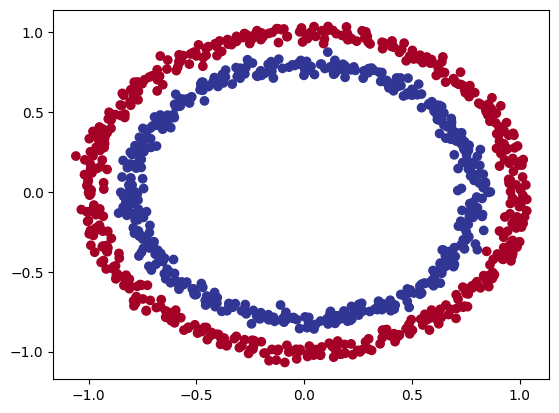

In [ ]:
# Visualize , visualize
import matplotlib.pyplot as plt
plt.scatter(x=X[:,0],
            y=X[:,1],
            c=y,
            cmap=plt.cm.RdYlBu)

Note- The data we're working with is often referred to as a toy dataset, a dataset that is small enough to experiment but still sizeable enough to pracrice the fundametals.

### 1.1 Checking the input and output shape

In [ ]:
X.shape,y.shape

((1000, 2), (1000,))

In [ ]:
# View the first example of features and labels
X_sample= X[0]
y_sample = y[0]

print(f"Values for one sample of X: {X_sample} and the same for y : {y_sample}")
print(f"Shapes for one sample of X: {X_sample.shape} and the same for y: {y_sample.shape}")

Values for one sample of X: [0.75424625 0.23148074] and the same for y : 1
Shapes for one sample of X: (2,) and the same for y: ()


### 1.2 Turn data into tensors and create train and test splits

In [ ]:
import torch

In [ ]:
X.dtype

dtype('float64')

In [ ]:
#Turn data into tensors
X= torch.from_numpy(X).type(torch.float)
y= torch.from_numpy(y).type(torch.float)

In [ ]:
type(X), X.dtype ,y.dtype

(torch.Tensor, torch.float32, torch.float32)

In [ ]:
# Split data into training and test sets

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X,y,
                                                    test_size=0.2,random_state=42)

In [ ]:
len(X_train)

800

In [ ]:
len(X_test)

200

## 2.Building a model

LET'S build a model to classify our blue and red dots.

to do so, we want to:
1. Setup device agonistic code so our code runs on GPU if available
2. Construct a model (by subclassing `nn.Module`)
3. Define a loss function and optimizer
4. create a training and test loop

In [ ]:
from torch import nn

#device agnostic code
device = 'cuda' if torch.cuda.is_available() else "cpu"
device

'cpu'

Let's create a model :
1. Subclasses `nn.Module` (almost all models in PyTorch subclass `nn.Module`)
2. Create 2 `nn.linear()` layers that are capable of handaling the shapes of our data
3. Defines a `forward()` method that outlines the forward pass (or forward computation) of the model

In [ ]:
X_train.shape

torch.Size([800, 2])

In [ ]:
# 1. Construct a model that subclasses nn.Module
class CircleModelV0(nn.Module):
  def __init__(self):
    super().__init__()
    #2. Create 2 nn.Linear layers capable of handaling the shapes of our data
    self.layer_1 = nn.Linear(in_features=2,out_features=5) # take in 2 features and upscales to 5 features
    self.layer_2 = nn.Linear(in_features=5,out_features=1) # take in 5 features from previous layer


  # 3. Define a forward() method that outlines the forward pass
  def forward(self,x):
    return self.layer_2(self.layer_1(x)) # x -> layer_1 -> layer_2 -> output

# 4. Instantiate an insatance of our model class and send it to the target device
model_0 = CircleModelV0().to(device)
model_0



CircleModelV0(
  (layer_1): Linear(in_features=2, out_features=5, bias=True)
  (layer_2): Linear(in_features=5, out_features=1, bias=True)
)

In [ ]:
model_0.to(device)

CircleModelV0(
  (layer_1): Linear(in_features=2, out_features=5, bias=True)
  (layer_2): Linear(in_features=5, out_features=1, bias=True)
)

In [ ]:
next(model_0.parameters()).device

device(type='cpu')

In [ ]:
# Lets replicate the model above using nn.Sequential()
model_0= nn.Sequential(
    nn.Linear(in_features=2,out_features=5),
    nn.Linear(in_features=5,out_features=1)
).to(device)
model_0

Sequential(
  (0): Linear(in_features=2, out_features=5, bias=True)
  (1): Linear(in_features=5, out_features=1, bias=True)
)

In [ ]:
model_0.state_dict()

OrderedDict([('0.weight',
              tensor([[-0.1622, -0.0618],
                      [-0.6398, -0.1207],
                      [ 0.6957,  0.4319],
                      [-0.0922, -0.5780],
                      [ 0.2113, -0.1523]])),
             ('0.bias', tensor([ 0.5808,  0.2390, -0.1546, -0.5409, -0.2728])),
             ('1.weight',
              tensor([[-0.1556, -0.2755, -0.2794,  0.2378, -0.2175]])),
             ('1.bias', tensor([0.1137]))])

In [ ]:
# make predictions
with torch.inference_mode():
  untrained_preds = model_0(X_test.to(device))
print(f"Length of predictions: {len(untrained_preds)}, Shape: {untrained_preds.shape}")
print(f"Length of test samples: {len(X_test)}, Shape: {X_test.shape}")
print(f"\nFirst 10 predictions:\n{untrained_preds[:10]}")
print(f"\nFirst 10 labels:\n{y_test[:10]}")

Length of predictions: 200, Shape: torch.Size([200, 1])
Length of test samples: 200, Shape: torch.Size([200, 2])

First 10 predictions:
tensor([[-0.1701],
        [-0.2444],
        [ 0.0314],
        [-0.2273],
        [ 0.0424],
        [-0.0030],
        [-0.2207],
        [-0.1642],
        [ 0.0306],
        [-0.2492]])

First 10 labels:
tensor([1., 0., 1., 0., 1., 1., 0., 0., 1., 0.])


### 2.1 Setup loss function and optimizer

Which loss function or optimizer should you use?

Again... this a problme specific.

For example for regression ypu might want MAE or MSE .

For classification you might want binary cross entropy or categorical cross entropy.

For loss function we're going to use `torch.nn.BECWithLogitsLoss()`


In [ ]:
# Setup the  loss function
# loss_fn = nn.BCELoss() # BCELoss = requires inputs to have gone through the sigmoid activation function
loss_fn = nn.BCEWithLogitsLoss() # Sigmoid activation function built in

optimizer = torch.optim.SGD(params = model_0.parameters(),
                            lr=0.1)

In [ ]:
# Calculate accuracy - out of 100 examples what percentage does our model get right?
def accuracy_fn(y_true, y_pred):
  correct = torch.eq(y_true,y_pred).sum().item()
  acc =(correct/len(y_pred))*100
  return acc


## 3. Train model

To train our model, we're going to need to build a training loop with the following steps:

1. Forward pass
2. calculate the loss
3. Optimizer zero grad
4. Loss backward (backpropogation)
5. Optimizer step(gradient descent)

### 3.1 Going from raw logits -> prediction probabilities -> prediction labels

Our model outputs are gling to be raw **logits**.

we can convert these **logits** into **prediction probabilities** by passing them to some kind of activation function (eg. sigmoid for binary classification and softmax for multiclass classification).

then we can convert our model's prediction probabilites to **prediction labels** by either rounding them or taking the `argmax()`

In [ ]:
model_0

Sequential(
  (0): Linear(in_features=2, out_features=5, bias=True)
  (1): Linear(in_features=5, out_features=1, bias=True)
)

In [ ]:
# View the first 5 outputs of the forward pass on the test data
model_0.eval()
with torch.inference_mode():
  y_logits = model_0(X_test.to(device))[:5]
y_logits

tensor([[-0.1701],
        [-0.2444],
        [ 0.0314],
        [-0.2273],
        [ 0.0424]])

In [ ]:
y_test[:5]

tensor([1., 0., 1., 0., 1.])

In [ ]:
# use the sigmoid activation function on our model logits to turn them into prediction probabilites
y_pred_probs = torch.sigmoid(y_logits)
y_pred_probs

tensor([[0.4576],
        [0.4392],
        [0.5078],
        [0.4434],
        [0.5106]])

for ou prediction probabilites values, we need to perform a range style roundning on them:
 * `y_pred_probs` >=0.5, `y=1` (class 1)
 * `y_pred_probs` <0.5, `y=0` (class 0)

In [ ]:
# find the predicted labels

y_preds = torch.round(y_pred_probs)

# In full
y_pred_labels = torch.round(torch.sigmoid(model_0(X_test.to(device))[:5]))

# Check for equality
print(torch.eq(y_preds.squeeze(), y_pred_labels.squeeze()))

# Get rid of extra dimesnion
y_preds.squeeze()

tensor([True, True, True, True, True])


tensor([0., 0., 1., 0., 1.])

In [ ]:
y_test[:5]

tensor([1., 0., 1., 0., 1.])

## 3.2 Building a training and testing loop

In [ ]:
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# Set the number of epochs
epochs =500

# put data to target device
X_train, X_test, y_train, y_test = X_train.to(device), X_test.to(device), y_train.to(device), y_test.to(device)

#Build training and evaluation loop

for epoch in range(epochs):
  ### Tarining
  model_0.train()

  # 1. Forward pass
  y_logits = model_0(X_train).squeeze()
  y_pred = torch.round(torch.sigmoid(y_logits))

  # 2. Caluculate loss/accuracy
  # loss = loss_fn(torch.sigmoid(y_logits), # nn.BCEWithLogitsLoss excepts raw logits as input
  #                y_train)
  loss = loss_fn(y_logits, # nn.BCEWithLogitsLoss excepts raw logits as input
                 y_train)
  acc = accuracy_fn(y_true=y_train,
                    y_pred=y_pred)

  # Optimizer zero grad
  optimizer.zero_grad()

  #4. Loss backward (backpropagation)
  loss.backward()

  #5. Optimizer step (gradient descent)
  optimizer.step()

  ### Testing
  model_0.eval()
  with torch.inference_mode():
    # 1.Forward pass
    test_logits = model_0(X_test).squeeze()
    test_pred = torch.round(torch.sigmoid(test_logits))

    # 2. Calculate loss/accuracy
    test_loss = loss_fn(test_logits,
                        y_test)
    test_acc = accuracy_fn(y_true=y_test,
                           y_pred=test_pred)

  # Print out whats happening
  if epoch % 10 == 0:
    print(f"Epoch: {epoch} | Loss: {loss:.5f}, Acc: {acc:.2f}% | Test Loss: {test_loss:.5f}, Test Acc: {test_acc:.2f}%")

Epoch: 0 | Loss: 0.69665, Acc: 47.38% | Test Loss: 0.69138, Test Acc: 53.50%
Epoch: 10 | Loss: 0.69564, Acc: 48.00% | Test Loss: 0.69108, Test Acc: 53.00%
Epoch: 20 | Loss: 0.69502, Acc: 48.50% | Test Loss: 0.69110, Test Acc: 53.00%
Epoch: 30 | Loss: 0.69460, Acc: 48.25% | Test Loss: 0.69125, Test Acc: 53.00%
Epoch: 40 | Loss: 0.69429, Acc: 48.88% | Test Loss: 0.69146, Test Acc: 52.50%
Epoch: 50 | Loss: 0.69406, Acc: 49.12% | Test Loss: 0.69167, Test Acc: 54.00%
Epoch: 60 | Loss: 0.69388, Acc: 48.88% | Test Loss: 0.69189, Test Acc: 53.00%
Epoch: 70 | Loss: 0.69373, Acc: 49.50% | Test Loss: 0.69211, Test Acc: 51.00%
Epoch: 80 | Loss: 0.69362, Acc: 50.25% | Test Loss: 0.69231, Test Acc: 51.50%
Epoch: 90 | Loss: 0.69353, Acc: 50.25% | Test Loss: 0.69249, Test Acc: 51.50%
Epoch: 100 | Loss: 0.69345, Acc: 50.25% | Test Loss: 0.69267, Test Acc: 48.50%
Epoch: 110 | Loss: 0.69339, Acc: 50.62% | Test Loss: 0.69282, Test Acc: 48.50%
Epoch: 120 | Loss: 0.69334, Acc: 50.88% | Test Loss: 0.69297, T

## 4. make predictions and evaluate the model

From the metrics it looks like our model isn't learning anything ....

So to inspect it lets make some predictions and make them visualize

In other words, "Visualize, visulaize, visualize !"

To do so we re going to import a function called `plot_decision_boundary`

In [ ]:
from urllib import request
import requests
from pathlib import Path

# Download helper functions from Learn Pytorch repo (if its not already downloaded)

if Path("helper_functions.py").is_file():
  print("helper_functions.py already exists, skipping download")
else:
  print("Downloading helper_functions.py")
  request = requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/helper_functions.py")
  with open("helper_functions.py","wb") as f:
    f.write(request.content)

from helper_functions import plot_decision_boundary,plot_predictions


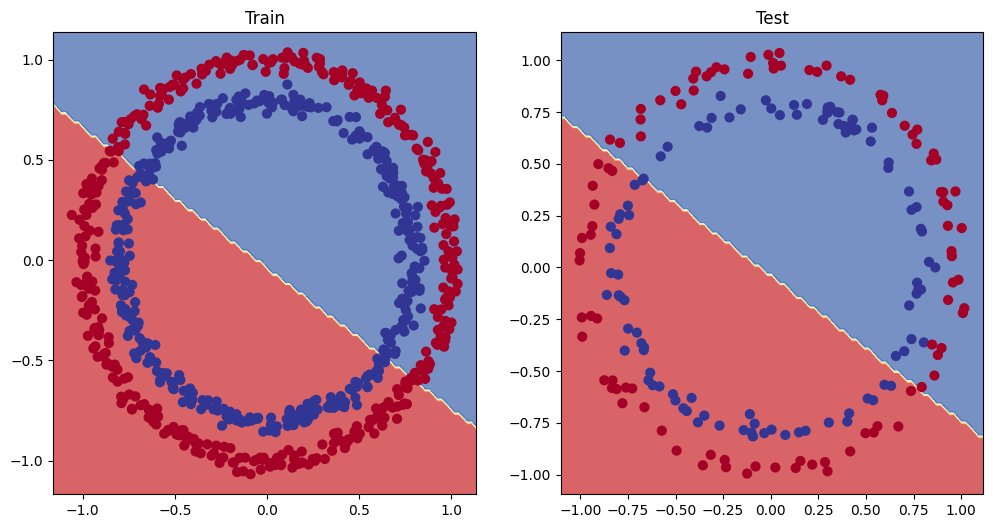

In [ ]:
# plot decision boundary of the model
plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
plt.title("Train")
plot_decision_boundary(model_0,X_train,y_train)
plt.subplot(1,2,2)
plt.title("Test")
plot_decision_boundary(model_0,X_test,y_test)


## 5. improving a model (from a model perspective)

* Add more layers - give the model more chances to learn about patterns in data
* Add more hidden units - go from 5 hidden units to 10 hidden units
* Fit for longer
* Changing the activation functions
* Change the learning rate
* Change the loss function

These options are all from a model's perspective because they deal directly with model, rather than the data

And because these options are all values we (as machine learning engineers and data scientists) can change, they are referred as hyperparameters

In [ ]:
model_0.state_dict()

OrderedDict([('0.weight',
              tensor([[-0.1572, -0.1095],
                      [-0.6309, -0.2116],
                      [ 0.6984,  0.3684],
                      [-0.0917, -0.5350],
                      [ 0.2193, -0.2260]])),
             ('0.bias', tensor([ 0.5811,  0.2397, -0.1567, -0.5379, -0.2719])),
             ('1.weight',
              tensor([[-0.1766, -0.3084, -0.1783,  0.0740, -0.2795]])),
             ('1.bias', tensor([0.1141]))])

In [ ]:
class CircleModelV1(nn.Module):
  def __init__(self):
    super().__init__()
    self.layer_1 = nn.Linear(in_features=2,out_features=10)
    self.layer_2 = nn.Linear(in_features=10,out_features=10)
    self.layer_3 = nn.Linear(in_features=10,out_features=1)

  def forward(self, x):
    # z= self.layer_1(x)
    # z= self.layer_2(z)
    # z= self.layer_3(z)
    return self.layer_3(self.layer_2(self.layer_1(x))) # the above functions can be written in onesingle step like this

model_1= CircleModelV1().to(device)
model_1

CircleModelV1(
  (layer_1): Linear(in_features=2, out_features=10, bias=True)
  (layer_2): Linear(in_features=10, out_features=10, bias=True)
  (layer_3): Linear(in_features=10, out_features=1, bias=True)
)

In [ ]:
loss_fn = nn.BCEWithLogitsLoss()

optimizer = torch.optim.SGD(params=model_1.parameters(),
                             lr = 0.1)

In [ ]:
torch.manual_seed(42)
epochs =1000

for epoch in range(epochs):
  model_1.train()
  logits= model_1(X_train.to(device)).squeeze()
  y_preds = torch.round(torch.sigmoid(logits))

  loss=loss_fn(y_preds,y_train.to(device))
  acc= accuracy_fn(y_train.to(device),y_preds)

  optimizer.zero_grad()

  loss.backward()

  optimizer.step()

  model_1.eval()

  with torch.inference_mode():
    test_logits = model_1(X_test.to(device)).squeeze()
    test_preds = torch.round(torch.sigmoid(test_logits))

    test_loss = loss_fn(test_preds,y_test.to(device))
    test_acc = accuracy_fn(y_true=y_test.to(device),y_pred=test_preds)

  if epoch %100 ==0:
    print(f"Epoch: {epoch} | Loss: {loss:.5f}, Acc: {acc:.2f}% | Test Loss: {test_loss:.5f}, Test Acc: {test_acc:.2f}%")



Epoch: 0 | Loss: 0.75769, Acc: 50.88% | Test Loss: 0.75541, Test Acc: 51.00%
Epoch: 100 | Loss: 0.75769, Acc: 50.88% | Test Loss: 0.75541, Test Acc: 51.00%
Epoch: 200 | Loss: 0.75769, Acc: 50.88% | Test Loss: 0.75541, Test Acc: 51.00%
Epoch: 300 | Loss: 0.75769, Acc: 50.88% | Test Loss: 0.75541, Test Acc: 51.00%
Epoch: 400 | Loss: 0.75769, Acc: 50.88% | Test Loss: 0.75541, Test Acc: 51.00%
Epoch: 500 | Loss: 0.75769, Acc: 50.88% | Test Loss: 0.75541, Test Acc: 51.00%
Epoch: 600 | Loss: 0.75769, Acc: 50.88% | Test Loss: 0.75541, Test Acc: 51.00%
Epoch: 700 | Loss: 0.75769, Acc: 50.88% | Test Loss: 0.75541, Test Acc: 51.00%
Epoch: 800 | Loss: 0.75769, Acc: 50.88% | Test Loss: 0.75541, Test Acc: 51.00%
Epoch: 900 | Loss: 0.75769, Acc: 50.88% | Test Loss: 0.75541, Test Acc: 51.00%


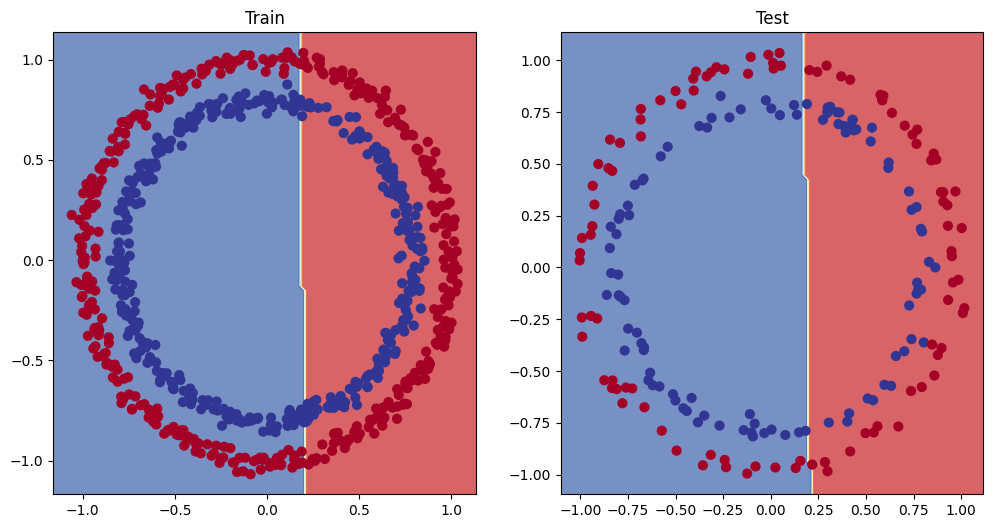

In [ ]:
# plot decision boundary of the model
plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
plt.title("Train")
plot_decision_boundary(model_1,X_train,y_train)
plt.subplot(1,2,2)
plt.title("Test")
plot_decision_boundary(model_1,X_test,y_test)

### 5.1 Preparing data to see if our model can fit a straight line

One way to troubleshoot to a larger problem is to test out a smaller problem

In [ ]:
# Create some dat (same as notebook 01)

weight =0.7
bias = 0.3

X_regression=torch.arange(0,1,0.01).unsqueeze(dim=1)
y_regression = weight*X_regression + bias # Linear regression formula

# Ckeck the data
print(len(X_regression))
X_regression[:5], y_regression[:5]

100


(tensor([[0.0000],
         [0.0100],
         [0.0200],
         [0.0300],
         [0.0400]]),
 tensor([[0.3000],
         [0.3070],
         [0.3140],
         [0.3210],
         [0.3280]]))

In [ ]:
# Create train and test spilts
train_split = int(0.8*len(X_regression))
X_train_regression , y_train_regression= X_regression[:train_split],y_regression[:train_split]
X_test_regression, y_test_regression = X_regression[train_split:], y_regression[train_split:]

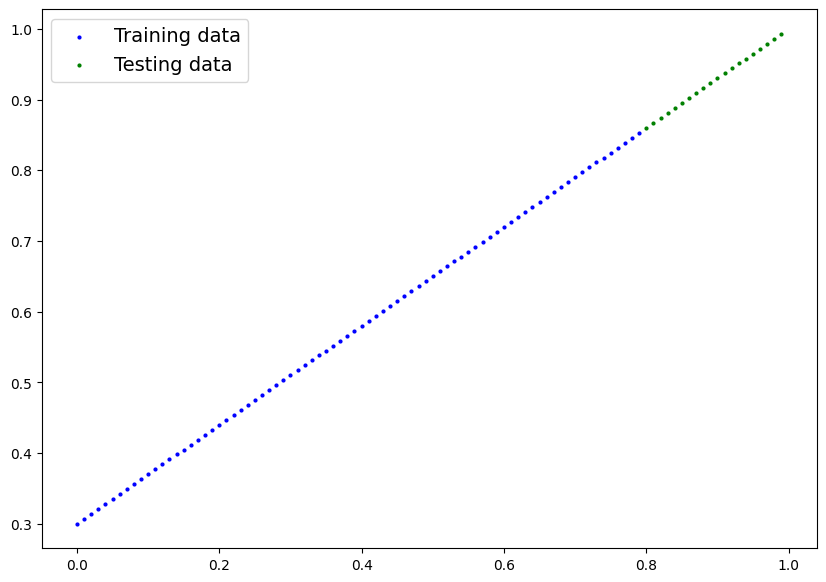

In [ ]:
plot_predictions(train_data = X_train_regression,
                 train_labels = y_train_regression,
                 test_data=X_test_regression,
                 test_labels=y_test_regression)

In [ ]:
model_1

CircleModelV1(
  (layer_1): Linear(in_features=2, out_features=10, bias=True)
  (layer_2): Linear(in_features=10, out_features=10, bias=True)
  (layer_3): Linear(in_features=10, out_features=1, bias=True)
)

### 5.2 Adjusting `model_1` to fit a straight line

In [ ]:
# Same architecture as model_1 (but using nn.squential())
model_2 = nn.Sequential(
    nn.Linear(in_features=1,out_features=10),
    nn.Linear(in_features =10, out_features=10),
    nn.Linear(in_features=10, out_features=1)
).to(device)

model_2

Sequential(
  (0): Linear(in_features=1, out_features=10, bias=True)
  (1): Linear(in_features=10, out_features=10, bias=True)
  (2): Linear(in_features=10, out_features=1, bias=True)
)

In [ ]:
# Loss and optimizer
loss_fn = nn.L1Loss()
optimizer = torch.optim.SGD(params=model_2.parameters(),
                            lr=0.01)

In [ ]:
# Train the model
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# Set the number of epochs
epochs =1000

for epoch in range(epochs):

  model_2.train()

  y_preds=model_2(X_train_regression)

  loss = loss_fn(y_preds,y_train_regression)


  optimizer.zero_grad()

  loss.backward()

  optimizer.step()

  # Test loop
  model_2.eval()
  with torch.inference_mode():
    test_preds = model_2(X_test_regression)
    test_loss = loss_fn(test_preds,y_test_regression)

  if epoch %100 ==0:
    print(f"Epoch: {epoch} | Loss: {loss:.5f}| Test Loss: {test_loss:.5f}")

Epoch: 0 | Loss: 0.75986| Test Loss: 0.91103
Epoch: 100 | Loss: 0.02858| Test Loss: 0.00081
Epoch: 200 | Loss: 0.02533| Test Loss: 0.00209
Epoch: 300 | Loss: 0.02137| Test Loss: 0.00305
Epoch: 400 | Loss: 0.01964| Test Loss: 0.00341
Epoch: 500 | Loss: 0.01940| Test Loss: 0.00387
Epoch: 600 | Loss: 0.01903| Test Loss: 0.00379
Epoch: 700 | Loss: 0.01878| Test Loss: 0.00381
Epoch: 800 | Loss: 0.01840| Test Loss: 0.00329
Epoch: 900 | Loss: 0.01798| Test Loss: 0.00360


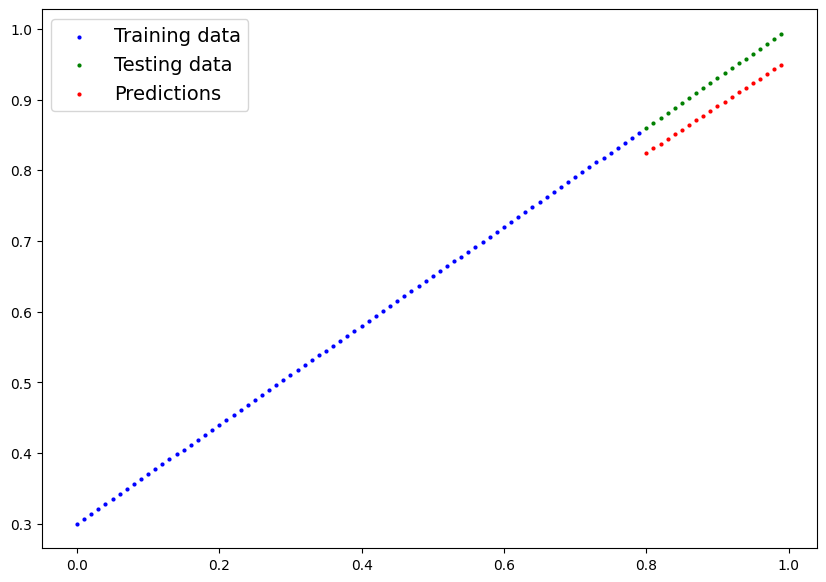

In [ ]:
# Turn on evaluation
model_2.eval()

with torch.inference_mode():
  y_preds = model_2(X_test_regression)

plot_predictions(train_data = X_train_regression,
                 train_labels = y_train_regression,
                 test_data=X_test_regression,
                 test_labels=y_test_regression,
                 predictions = y_preds)

### 6. The missing piece : non-linearity

"What patterns could you draw if you were given an infinte amount of a straight and non-straight lines?"
Or in machine learning terms, an infinite (but really it is finite) of linear and non linear functions?

## 6.1 Recreating non-linear data

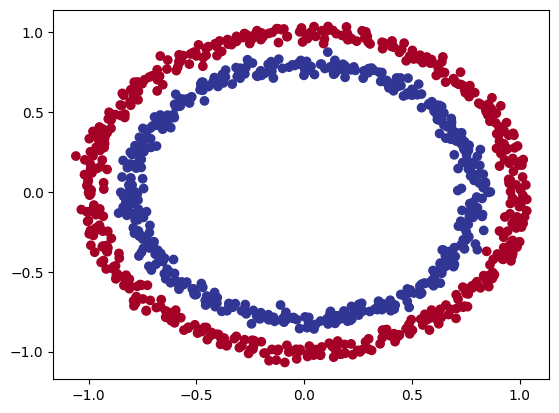

In [ ]:
# Make a plot data
from sklearn.datasets import make_circles
n_samples=1000

X,y = make_circles(n_samples,noise=0.03,
                   random_state=42)

plt.scatter(X[:,0], X[:,1],c=y, cmap=plt.cm.RdYlBu)

In [ ]:
# Convert data into tensors
X= torch.from_numpy(X).type(torch.float)
y=torch.from_numpy(y).type(torch.float)

X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2,random_state=42)

X_train[:5],y_train[:5]

(tensor([[ 0.6579, -0.4651],
         [ 0.6319, -0.7347],
         [-1.0086, -0.1240],
         [-0.9666, -0.2256],
         [-0.1666,  0.7994]]),
 tensor([1., 0., 0., 0., 1.]))

### 6.2 Building a model with non-linearity

Artifical neural networks are a large combination of linear (straight) and non-straight (non-linear) functions which are potentially able to find patterns in data

In [ ]:
# Build a model with a non-linear function
from torch import nn
class CircleModelV2(nn.Module):
  def __init__(self):
    super().__init__()
    self.layer_1 = nn.Linear(in_features=2,out_features=10)
    self.layer_2 = nn.Linear(in_features=10,out_features=10)
    self.layer_3 = nn.Linear(in_features=10,out_features=1)
    self.relu = nn.ReLU() # relu is a non linear activation function

  def forward(self,x):
    # Where should we put our non linear activation functions?
    return self.layer_3(self.relu(self.layer_2(self.relu(self.layer_1(x)))))

model_3 = CircleModelV2().to(device)
model_3

CircleModelV2(
  (layer_1): Linear(in_features=2, out_features=10, bias=True)
  (layer_2): Linear(in_features=10, out_features=10, bias=True)
  (layer_3): Linear(in_features=10, out_features=1, bias=True)
  (relu): ReLU()
)

In [ ]:
loss_fn = nn.BCEWithLogitsLoss()
optimizer = torch.optim.SGD(params=model_3.parameters(),
                            lr=0.1)

In [ ]:
model_3.state_dict()

OrderedDict([('layer_1.weight',
              tensor([[ 0.5406,  0.5869],
                      [-0.1657,  0.6496],
                      [-0.1549,  0.1427],
                      [-0.3443,  0.4153],
                      [ 0.6233, -0.5188],
                      [ 0.6146,  0.1323],
                      [ 0.5224,  0.0958],
                      [ 0.3410, -0.0998],
                      [ 0.5451,  0.1045],
                      [-0.3301,  0.1802]])),
             ('layer_1.bias',
              tensor([-0.3258, -0.0829, -0.2872,  0.4691, -0.5582, -0.3260, -0.1997, -0.4252,
                       0.0667, -0.6984])),
             ('layer_2.weight',
              tensor([[ 0.2856, -0.2686,  0.2441,  0.0526, -0.1027,  0.1954,  0.0493,  0.2555,
                        0.0346, -0.0997],
                      [ 0.0850, -0.0858,  0.1331,  0.2823,  0.1828, -0.1382,  0.1825,  0.0566,
                        0.1606, -0.1927],
                      [-0.3130, -0.1222, -0.2426,  0.2595,  0.0911,  0.1

In [ ]:
# training the model
torch.manual_seed(42)
torch.cuda.manual_seed(42)

epochs=1000
X_train, X_test, y_train, y_test = X_train.to(device), X_test.to(device), y_train.to(device), y_test.to(device)

for epoch in range(epochs):
  model_3.train()
  y_logits = model_3(X_train).squeeze()
  y_preds=torch.round(torch.sigmoid(y_logits))
  loss = loss_fn(y_logits,y_train)
  acc = accuracy_fn(y_true= y_train, y_pred=y_preds)
  optimizer.zero_grad()
  loss.backward()
  optimizer.step()

  model_3.eval()
  with torch.inference_mode():
    test_logits = model_3(X_test).squeeze()
    test_preds=torch.round(torch.sigmoid(test_logits))
    test_loss = loss_fn(test_logits,y_test)
    test_acc = accuracy_fn(y_true = y_test,y_pred=test_preds)

  if epoch % 100 ==0:
    print(f"Epoch: {epoch} | Loss: {loss:.5f}, Acc: {acc:.2f}% | Test Loss: {test_loss:.5f}, Test Acc: {test_acc:.2f}%")


Epoch: 0 | Loss: 0.69295, Acc: 50.00% | Test Loss: 0.69319, Test Acc: 50.00%
Epoch: 100 | Loss: 0.69115, Acc: 52.88% | Test Loss: 0.69102, Test Acc: 52.50%
Epoch: 200 | Loss: 0.68977, Acc: 53.37% | Test Loss: 0.68940, Test Acc: 55.00%
Epoch: 300 | Loss: 0.68795, Acc: 53.00% | Test Loss: 0.68723, Test Acc: 56.00%
Epoch: 400 | Loss: 0.68517, Acc: 52.75% | Test Loss: 0.68411, Test Acc: 56.50%
Epoch: 500 | Loss: 0.68102, Acc: 52.75% | Test Loss: 0.67941, Test Acc: 56.50%
Epoch: 600 | Loss: 0.67515, Acc: 54.50% | Test Loss: 0.67285, Test Acc: 56.00%
Epoch: 700 | Loss: 0.66659, Acc: 58.38% | Test Loss: 0.66322, Test Acc: 59.00%
Epoch: 800 | Loss: 0.65160, Acc: 64.00% | Test Loss: 0.64757, Test Acc: 67.50%
Epoch: 900 | Loss: 0.62362, Acc: 74.00% | Test Loss: 0.62145, Test Acc: 79.00%


### 6.4 Evaluating a model trained with non-linear activation functions

In [ ]:
model_3.eval()
with torch.inference_mode():
  y_preds = torch.round(torch.sigmoid(model_3(X_test).squeeze()))
y_preds[:10], y_test[:10]

(tensor([1., 0., 1., 0., 0., 1., 0., 0., 1., 0.]),
 tensor([1., 0., 1., 0., 1., 1., 0., 0., 1., 0.]))

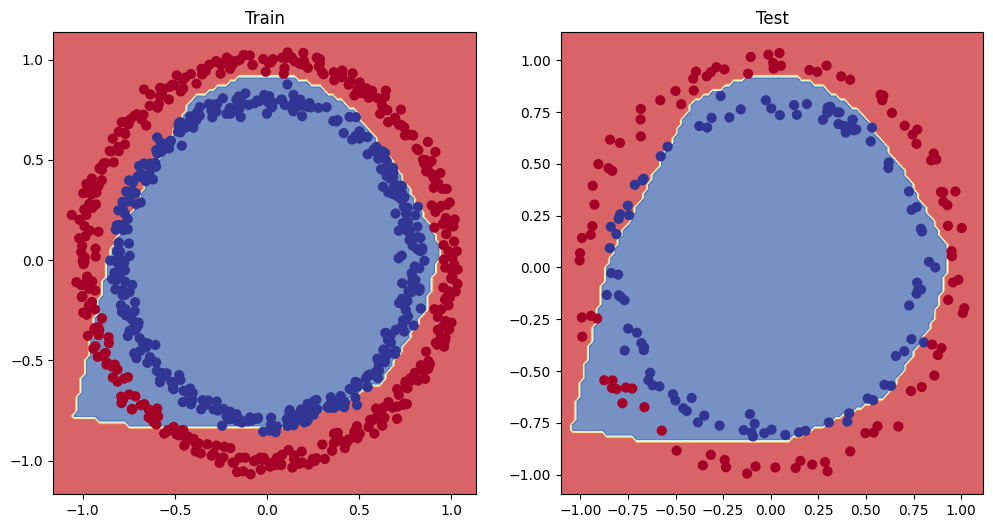

In [ ]:
plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
plt.title("Train")
plot_decision_boundary(model_3,X_train,y_train)
plt.subplot(1,2,2)
plt.title("Test")
plot_decision_boundary(model_3,X_test,y_test)

## 7. Replicating non-linear activation functions
Neural networks, rather than us telling the model what to learn, we give it the tools to discover patterns in data and it tries to figure out the patterns on its own.

And these tools are linear & non-linear activation fuctions

In [ ]:
# Create a tensor
A= torch.arange(-10,10,1,dtype =torch.float32)
A.dtype

torch.float32

In [ ]:
A

tensor([-10.,  -9.,  -8.,  -7.,  -6.,  -5.,  -4.,  -3.,  -2.,  -1.,   0.,   1.,
          2.,   3.,   4.,   5.,   6.,   7.,   8.,   9.])

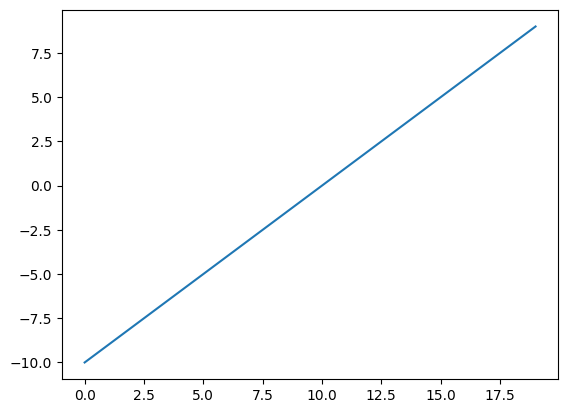

In [ ]:
plt.plot(A)

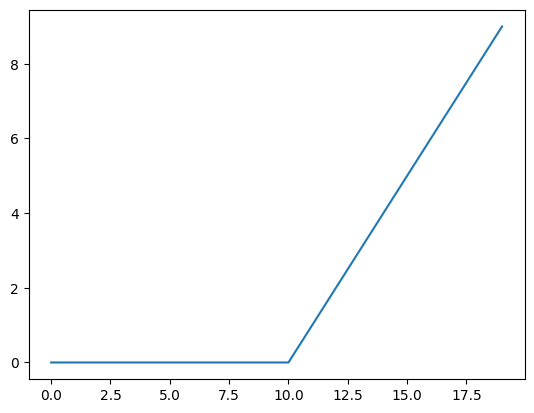

In [ ]:
plt.plot(torch.relu(A))

In [ ]:
def relu(x: torch.Tensor) -> torch.Tensor:
  return torch.maximum(torch.tensor(0), x)

relu(A)

tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 2., 3., 4., 5., 6., 7.,
        8., 9.])

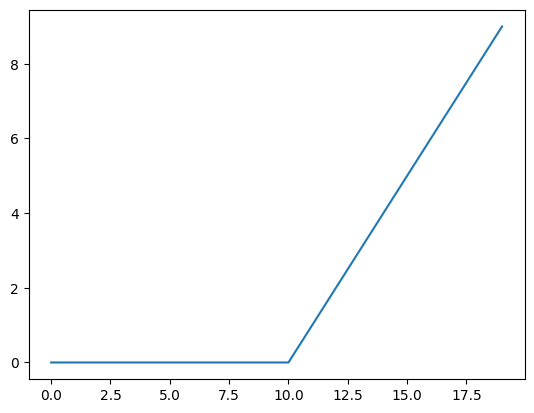

In [ ]:
plt.plot(relu(A));

In [ ]:
def sigmoid(x):
  return 1/(1+torch.exp(-x))

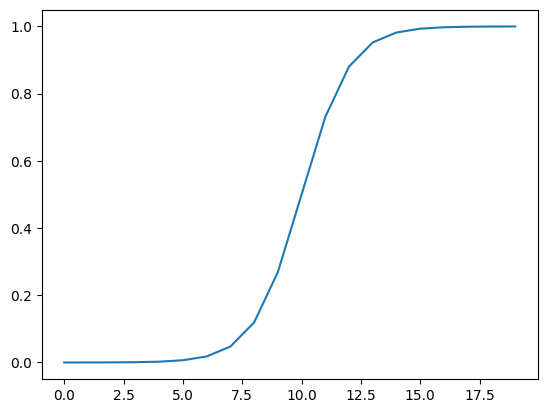

In [ ]:
plt.plot(torch.sigmoid(A))

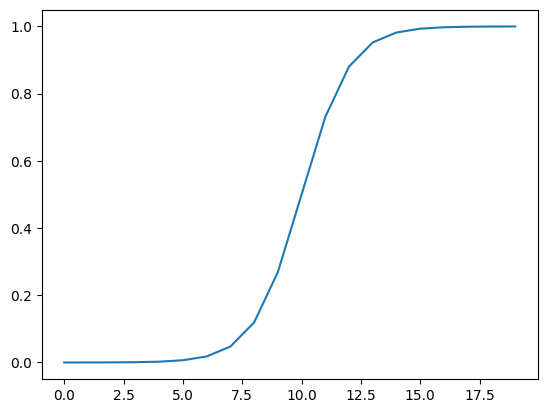

In [ ]:
plt.plot(sigmoid(A))

## 8.Putting it all together with a multi-class classification problem
* Binary classification = one thing or another
* Multi class classification = more than one thing or another

### 8.1 Import dependencies

torch.Size([1000]) torch.Size([200])


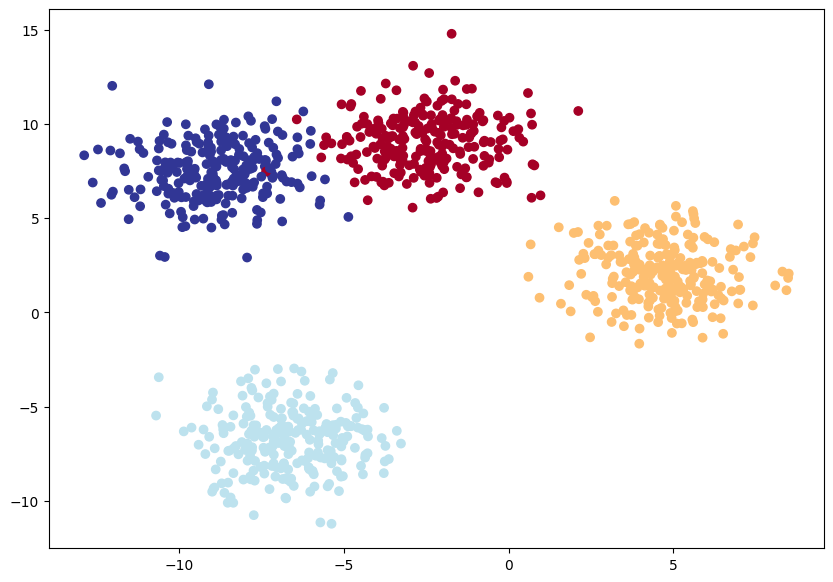

In [ ]:
# Import dependencies
import torch
import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs
from sklearn.model_selection import train_test_split

# Set the hyperparameters for data creation
NUM_ClASSES =4
NUM_FEATURES =2
RANDOM_SEED = 42

X_blob,y_blob = make_blobs(n_samples = 1000,
                           n_features=NUM_FEATURES,
                           centers=NUM_ClASSES,
                           cluster_std=1.5, # give the clusters a little shake up
                           random_state=RANDOM_SEED)

# 2. Tuen data into tensors
X_blob = torch.from_numpy(X_blob).type(torch.float)
y_blob = torch.from_numpy(y_blob).type(torch.LongTensor)

# 3. Split into train and test
X_blob_train, X_blob_test, y_blob_train , y_blob_test = train_test_split(X_blob,y_blob,test_size=0.2,random_state=RANDOM_SEED)
print(y_blob.shape,y_blob_test.shape)
# 4. Plot data (visualize,visualize,visulaize)
plt.figure(figsize=(10,7))
plt.scatter(X_blob[:,0],X_blob[:,1], c=y_blob , cmap = plt.cm.RdYlBu)

### 8.2 Building a multiclass classification model in PyTorch

In [ ]:
# Create device agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cpu'

In [ ]:
class BlobModel(nn.Module):
  def __init__(self, input_features, output_features, hidden_units=8):
    """Intializes multi-class classification model.

    Args:
      input_features (int): Number of inpur features to the model
      output_features (int): Number of outputs features (number of output classes)
      hidden_units (int): Number of hidden units between layers, default 8
    """
    super().__init__()
    self.linear_layer_stack = nn.Sequential(
        nn.Linear(in_features = input_features, out_features= hidden_units),
        nn.ReLU(),
        nn.Linear(in_features= hidden_units, out_features = hidden_units),
        nn.ReLU(),
        nn.Linear(in_features = hidden_units,out_features=output_features)
    )

  def forward(self,x):
    return self.linear_layer_stack(x)

model_4  =BlobModel(input_features=2,
                    output_features=4,
                    hidden_units=8
                    ).to(device)

model_4

BlobModel(
  (linear_layer_stack): Sequential(
    (0): Linear(in_features=2, out_features=8, bias=True)
    (1): ReLU()
    (2): Linear(in_features=8, out_features=8, bias=True)
    (3): ReLU()
    (4): Linear(in_features=8, out_features=4, bias=True)
  )
)

### 8.3 Create loss and optimizer for multi-class classification model

In [ ]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(params=model_4.parameters(),
                            lr=0.1)

### 8.4 Getting prediction probabilites for a multi-class Pytorch model
In order to evaluate and train and test our model, we need to convert our model's outputs(logits) to prediction probabvilites and then to prediction labels.

Logits-> pred prob -> labels

In [ ]:
model_4.eval()
with torch.inference_mode():
  y_logits = model_4(X_blob_test)
y_logits[:10]

tensor([[-0.7646, -0.7412, -1.5777, -1.1376],
        [-0.0973, -0.9431, -0.5963, -0.1371],
        [ 0.2528, -0.2379,  0.1882, -0.0066],
        [-0.4134, -0.5204, -0.9303, -0.6963],
        [-0.3118, -1.3736, -1.1991, -0.3834],
        [-0.1497, -1.0617, -0.7107, -0.1645],
        [ 0.1539, -0.2887,  0.1520, -0.0109],
        [-0.2154, -1.1795, -0.9300, -0.2745],
        [ 0.2443, -0.2472,  0.1649,  0.0061],
        [-0.2329, -1.2120, -0.9849, -0.3004]])

In [ ]:
y_blob_test[:5]

tensor([1, 3, 2, 1, 0])

In [ ]:
y_pred_probs = torch.softmax(y_logits,dim=1)
print(y_logits[:5])
print(y_pred_probs[:5])

tensor([[-0.7646, -0.7412, -1.5777, -1.1376],
        [-0.0973, -0.9431, -0.5963, -0.1371],
        [ 0.2528, -0.2379,  0.1882, -0.0066],
        [-0.4134, -0.5204, -0.9303, -0.6963],
        [-0.3118, -1.3736, -1.1991, -0.3834]])
tensor([[0.3169, 0.3244, 0.1405, 0.2182],
        [0.3336, 0.1432, 0.2026, 0.3206],
        [0.3011, 0.1843, 0.2823, 0.2323],
        [0.3078, 0.2766, 0.1836, 0.2320],
        [0.3719, 0.1286, 0.1532, 0.3463]])


In [ ]:
# Converting our model's prediction probaabilites to prediction labels
y_preds = torch.argmax(y_pred_probs,dim=1)
y_preds

tensor([1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 3, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0,
        1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 0, 0, 1, 0, 1, 0, 0, 0,
        0, 0, 0, 0, 3, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0,
        1, 0, 0, 0, 0, 1, 0, 1])

In [ ]:
y_blob_test

tensor([1, 3, 2, 1, 0, 3, 2, 0, 2, 0, 0, 1, 0, 0, 0, 3, 3, 2, 3, 3, 3, 0, 1, 2,
        2, 2, 3, 0, 1, 0, 3, 1, 1, 3, 1, 2, 1, 3, 0, 2, 0, 3, 3, 2, 0, 3, 1, 1,
        0, 3, 1, 0, 1, 1, 3, 2, 1, 1, 3, 2, 2, 0, 3, 2, 2, 0, 0, 3, 3, 0, 0, 3,
        3, 3, 2, 3, 3, 3, 3, 1, 0, 2, 3, 2, 3, 3, 2, 3, 3, 2, 3, 3, 1, 3, 3, 3,
        1, 0, 3, 2, 0, 0, 3, 0, 2, 3, 1, 0, 3, 2, 1, 1, 0, 2, 2, 3, 0, 0, 1, 2,
        2, 3, 0, 1, 2, 0, 0, 0, 2, 3, 1, 2, 3, 2, 0, 3, 0, 0, 1, 1, 1, 0, 2, 2,
        2, 2, 0, 3, 3, 2, 2, 1, 3, 2, 0, 0, 3, 3, 2, 1, 2, 0, 3, 2, 0, 3, 2, 0,
        2, 2, 2, 0, 3, 1, 1, 1, 1, 1, 3, 1, 0, 2, 2, 1, 2, 2, 0, 1, 2, 2, 0, 0,
        1, 3, 2, 0, 3, 1, 2, 1])

### 8.5 Creating a training loop and testing loop for a multi-class PyTorch model

In [ ]:
# Training loop
torch.manual_seed(42)
torch.cuda.manual_seed(42)

epochs =100
X_blob_train, X_blob_test, y_blob_train , y_blob_test = X_blob_train.to(device), X_blob_test.to(device), y_blob_train.to(device), y_blob_test.to(device)

for epoch in range(epochs):

  model_4.train()

  y_logits = model_4(X_blob_train)
  y_pred_prob = torch.softmax(y_logits,dim=1)
  y_preds = torch.argmax(y_pred_prob,dim=1)

  loss = loss_fn(y_logits,y_blob_train)
  acc = accuracy_fn(y_true = y_blob_train,y_pred=y_preds)

  optimizer.zero_grad()
  loss.backward()
  optimizer.step()

  # Testing loop
  model_4.eval()
  with torch.inference_mode():
    test_logits = model_4(X_blob_test)
    test_pred_prob = torch.softmax(test_logits,dim=1)
    test_preds= torch.argmax(test_pred_prob,dim=1)
    test_loss = loss_fn(test_logits,y_blob_test)
    test_acc = accuracy_fn(y_true=y_blob_test,y_pred=test_preds)
  if epoch %10 == 0:
    print(f"Epoch: {epoch} | Loss: {loss:.5f}, Acc: {acc:.2f}% | Test Loss: {test_loss:.5f}, Test Acc: {test_acc:.2f}%")


Epoch: 0 | Loss: 1.15883, Acc: 40.38% | Test Loss: 1.07554, Test Acc: 48.00%
Epoch: 10 | Loss: 0.64476, Acc: 96.75% | Test Loss: 0.66069, Test Acc: 97.50%
Epoch: 20 | Loss: 0.42535, Acc: 98.50% | Test Loss: 0.43074, Test Acc: 100.00%
Epoch: 30 | Loss: 0.25294, Acc: 99.12% | Test Loss: 0.24508, Test Acc: 99.50%
Epoch: 40 | Loss: 0.11232, Acc: 99.25% | Test Loss: 0.10229, Test Acc: 99.50%
Epoch: 50 | Loss: 0.06627, Acc: 99.25% | Test Loss: 0.05848, Test Acc: 99.50%
Epoch: 60 | Loss: 0.05068, Acc: 99.25% | Test Loss: 0.04293, Test Acc: 99.50%
Epoch: 70 | Loss: 0.04300, Acc: 99.25% | Test Loss: 0.03491, Test Acc: 99.50%
Epoch: 80 | Loss: 0.03836, Acc: 99.25% | Test Loss: 0.02988, Test Acc: 99.50%
Epoch: 90 | Loss: 0.03525, Acc: 99.25% | Test Loss: 0.02663, Test Acc: 99.50%


In [ ]:
model_4.eval()
with torch.inference_mode():
  y_logits = model_4(X_blob_test)
  y_preds = torch.softmax(y_logits,dim=1).argmax(dim=1)

In [ ]:
y_preds

tensor([1, 3, 2, 1, 0, 3, 2, 0, 2, 0, 0, 1, 0, 0, 0, 3, 3, 2, 3, 3, 3, 0, 1, 2,
        2, 2, 3, 0, 1, 0, 3, 1, 1, 3, 1, 2, 1, 3, 0, 2, 0, 3, 3, 2, 0, 3, 1, 1,
        0, 3, 1, 0, 1, 1, 3, 2, 1, 1, 3, 2, 2, 0, 3, 2, 2, 0, 0, 3, 3, 0, 0, 3,
        3, 3, 2, 3, 3, 3, 3, 1, 0, 2, 3, 2, 3, 3, 2, 3, 3, 2, 3, 3, 1, 3, 3, 3,
        1, 0, 3, 2, 0, 0, 3, 0, 2, 3, 1, 0, 3, 2, 1, 1, 0, 2, 2, 3, 0, 0, 1, 2,
        2, 3, 0, 1, 2, 0, 0, 0, 2, 3, 1, 2, 3, 2, 0, 3, 0, 0, 1, 1, 1, 0, 2, 2,
        2, 2, 0, 3, 0, 2, 2, 1, 3, 2, 0, 0, 3, 3, 2, 1, 2, 0, 3, 2, 0, 3, 2, 0,
        2, 2, 2, 0, 3, 1, 1, 1, 1, 1, 3, 1, 0, 2, 2, 1, 2, 2, 0, 1, 2, 2, 0, 0,
        1, 3, 2, 0, 3, 1, 2, 1])

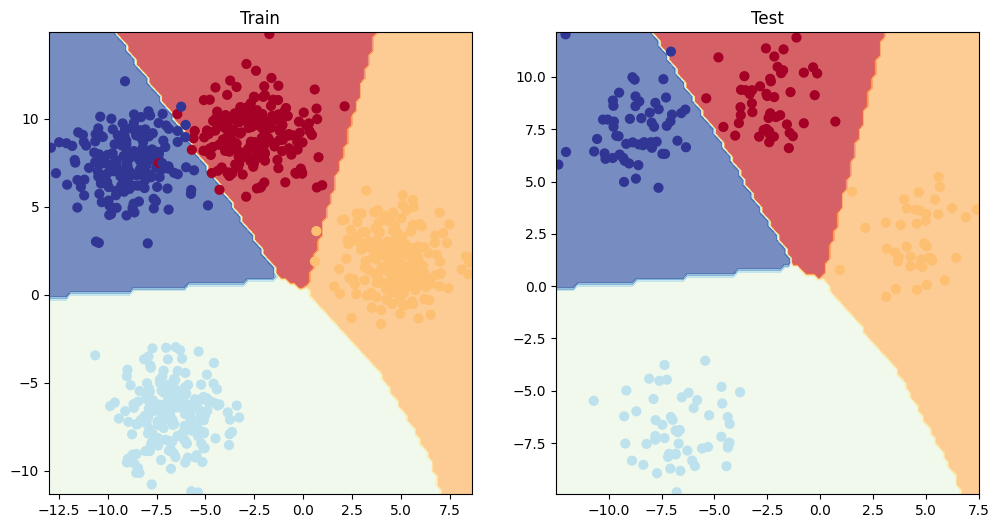

In [ ]:
plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
plt.title("Train")
plot_decision_boundary(model_4,X_blob_train,y_blob_train)
plt.subplot(1,2,2)
plt.title("Test")
plot_decision_boundary(model_4,X_blob_test,y_blob_test)

### 9. A few more classification metrics...

* Accuracy - out of 100 samples , how many does our model get right?
* Precision
* Recall
* F1- score
* Confusion matrix
* Classification report

In [ ]:
!pip install torchmetrics

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 931.7/931.7 kB 14.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 2.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 89.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 71.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 45.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 11.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 8.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 4.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 73.8 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstall

In [ ]:
from torchmetrics import Accuracy

torchmetric_accuracy  = Accuracy(task="multiclass",num_classes=4).to(device )

torchmetric_accuracy(y_preds,y_blob_test)

tensor(0.9950)

In [ ]:
from sklearn.datasets import make_moons

In [ ]:
X_moons, y_moons = make_moons(n_samples=1000, noise=0.075,random_state =42)

In [ ]:
X_moons[:5]

array([[-0.03642046,  0.42519235],
       [ 1.00435868, -0.43903211],
       [ 0.88597534, -0.31567332],
       [ 0.33310708, -0.42285289],
       [-0.83768234,  0.5328218 ]])

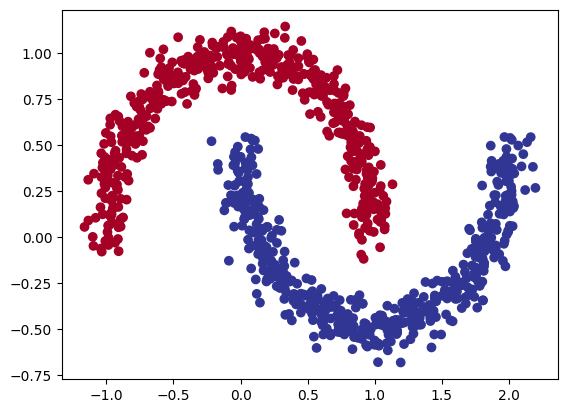

In [ ]:
plt.scatter(X_moons[:,0],X_moons[:,1], c=y_moons, cmap=plt.cm.RdYlBu)

In [ ]:
X_moons = torch.from_numpy(X_moons).type(torch.float)
y_moons = torch.from_numpy(y_moons).type(torch.float)

In [ ]:
from sklearn.model_selection import train_test_split
X_moons_train,X_moons_test,y_moons_train,y_moons_test= train_test_split(X_moons,y_moons,test_size=0.2,random_state=42)

In [132]:
class MoonModel(nn.Module):
  def __init__(self):
    super().__init__()
    self.linear_stack = nn.Sequential(
        nn.Linear(in_features=2,out_features = 10),
        nn.ReLU(),
        nn.Linear(in_features=10,out_features=10),
        nn.ReLU(),
        nn.Linear(in_features=10,out_features =1)
    )

  def forward(self,x):
    return self.linear_stack(x)

In [133]:
model_5 = MoonModel()

In [134]:
model_5

MoonModel(
  (linear_stack): Sequential(
    (0): Linear(in_features=2, out_features=10, bias=True)
    (1): ReLU()
    (2): Linear(in_features=10, out_features=10, bias=True)
    (3): ReLU()
    (4): Linear(in_features=10, out_features=1, bias=True)
  )
)

In [135]:
loss_fn = nn.BCEWithLogitsLoss()
optimizer = torch.optim.SGD(params=model_5.parameters(),
                            lr=0.1)

In [142]:
# Training loop
torch.manual_seed(42)
torch.cuda.manual_seed(42)

epochs=100
X_moons_train,X_moons_test,y_moons_train,y_moons_test= X_moons_train.to(device),X_moons_test.to(device),y_moons_train.to(device),y_moons_test.to(device)

for epoch in range(epochs):

  model_5.train()

  y_logits=model_5(X_moons_train).squeeze()
  y_preds= torch.round(torch.sigmoid(y_logits))

  loss =loss_fn(y_logits,y_moons_train)
  acc = accuracy_fn(y_true=y_moons_train,y_pred=y_preds)

  optimizer.zero_grad()

  loss.backward()

  optimizer.step()

  # testing

  model_5.eval()
  with torch.inference_mode():
    test_logits = model_5(X_moons_test).squeeze()
    test_preds = torch.round(torch.sigmoid(test_logits))
    test_loss = loss_fn(test_logits,y_moons_test)

    test_acc = accuracy_fn(y_true=y_moons_test,y_pred=test_preds)

  if epoch%10 == 0:
    print(f"Epoch: {epoch} | Loss: {loss:.5f}, Acc: {acc:.2f}% | Test Loss: {test_loss:.5f}, Test Acc: {test_acc:.2f}%")

Epoch: 0 | Loss: 0.12612, Acc: 95.00% | Test Loss: 0.11391, Test Acc: 96.00%
Epoch: 10 | Loss: 0.12180, Acc: 95.12% | Test Loss: 0.10973, Test Acc: 96.00%
Epoch: 20 | Loss: 0.11743, Acc: 95.50% | Test Loss: 0.10552, Test Acc: 97.00%
Epoch: 30 | Loss: 0.11311, Acc: 95.50% | Test Loss: 0.10128, Test Acc: 97.50%
Epoch: 40 | Loss: 0.10886, Acc: 96.00% | Test Loss: 0.09715, Test Acc: 97.50%
Epoch: 50 | Loss: 0.10468, Acc: 96.12% | Test Loss: 0.09312, Test Acc: 97.50%
Epoch: 60 | Loss: 0.10062, Acc: 96.38% | Test Loss: 0.08915, Test Acc: 97.50%
Epoch: 70 | Loss: 0.09670, Acc: 96.62% | Test Loss: 0.08535, Test Acc: 98.50%
Epoch: 80 | Loss: 0.09297, Acc: 97.00% | Test Loss: 0.08174, Test Acc: 98.50%
Epoch: 90 | Loss: 0.08940, Acc: 97.38% | Test Loss: 0.07830, Test Acc: 98.50%


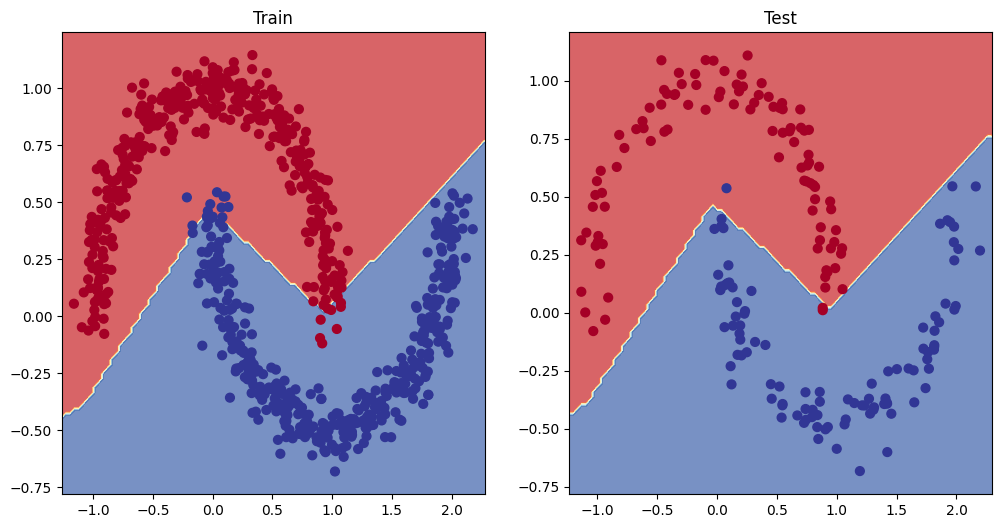

In [143]:
plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
plt.title("Train")
plot_decision_boundary(model_5,X_moons_train,y_moons_train)
plt.subplot(1,2,2)
plt.title("Test")
plot_decision_boundary(model_5,X_moons_test,y_moons_test)

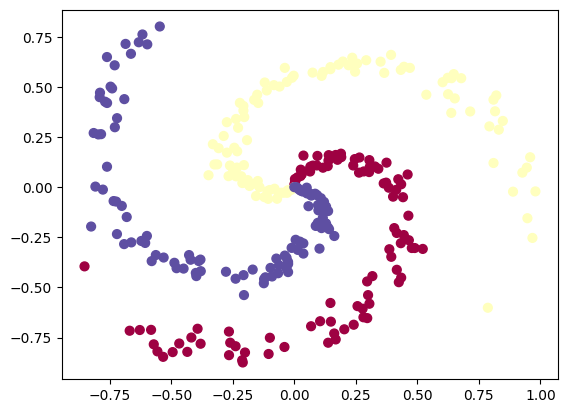

In [144]:
import numpy as np
N = 100 # number of points per class
D = 2 # dimensionality
K = 3 # number of classes
X = np.zeros((N*K,D)) # data matrix (each row = single example)
y = np.zeros(N*K, dtype='uint8') # class labels
for j in range(K):
  ix = range(N*j,N*(j+1))
  r = np.linspace(0.0,1,N) # radius
  t = np.linspace(j*4,(j+1)*4,N) + np.random.randn(N)*0.2 # theta
  X[ix] = np.c_[r*np.sin(t), r*np.cos(t)]
  y[ix] = j
# lets visualize the data
plt.scatter(X[:, 0], X[:, 1], c=y, s=40, cmap=plt.cm.Spectral)
plt.show()